In [3]:
import networkx as nx
import dwave_networkx as dnx

from dqanneal.graph.embed import (get_problem_graph, 
                                  embed_problem_onto_hardware, 
                                  define_embedded_qubo_problem,
                                  unembed_samples,
                                  build_reverse_annealing_schedule_embedding)
from dqanneal.solvers.solvers import dimod_optimizer_cloud, save_annealing_results
import numpy as np

In [1]:
import dimod
import minorminer
import dwave # same as: dwave-ocean-sdk  
import dwaveoceansdk


print(dimod.__version__)
print(minorminer.__version__)
print(dwaveoceansdk.__version__)


0.12.18
0.2.16
8.1.0


# Define the QUBO problem

In [24]:
dwave_qubo = dict()
for i in range(1,7):
    for j in range(i,7):
        dwave_qubo[(i,j)] = np.random.randint(1,10)

dwave_qubo


{(1, 1): 5,
 (1, 2): 2,
 (1, 3): 5,
 (1, 4): 8,
 (1, 5): 2,
 (1, 6): 3,
 (2, 2): 5,
 (2, 3): 2,
 (2, 4): 8,
 (2, 5): 7,
 (2, 6): 8,
 (3, 3): 8,
 (3, 4): 6,
 (3, 5): 2,
 (3, 6): 3,
 (4, 4): 1,
 (4, 5): 4,
 (4, 6): 4,
 (5, 5): 1,
 (5, 6): 7,
 (6, 6): 4}

In [25]:
source_bqm = dimod.BinaryQuadraticModel.from_qubo(dwave_qubo)
print(f'numbera of variables: {len(source_bqm.variables)}')

numbera of variables: 6


In [26]:
problem_graph, problem_edge_dict = get_problem_graph(dwave_qubo)
nx.get_edge_attributes(problem_graph, "bias")

{(1, 2): 2.0,
 (1, 3): 5.0,
 (1, 4): 8.0,
 (1, 5): 2.0,
 (1, 6): 3.0,
 (2, 3): 2.0,
 (2, 4): 8.0,
 (2, 5): 7.0,
 (2, 6): 8.0,
 (3, 4): 6.0,
 (3, 5): 2.0,
 (3, 6): 3.0,
 (4, 5): 4.0,
 (4, 6): 4.0,
 (5, 6): 7.0}

# build a hardware graph

In [27]:
from dqanneal.graph.embed import create_king_graph

hardware_graph, hardware_graph_edge_dict, pos = create_king_graph(4,4)

In [28]:
# # https://docs.ocean.dwavesys.com/en/latest/docs_dnx/reference/generators.html
# # G = dnx.chimera_graph(1, 1, 4)
# # G = dnx.zephyr_graph(6)

# # https://github.com/dwave-examples/pegasus-notebook/blob/master/01-exploring-pegasus.ipynb
# hardware_graph = dnx.pegasus_graph(16)
# hardware_graph_edge_dict = {node: set(hardware_graph.neighbors(node)) for node in hardware_graph.nodes}

# embed given problem onto hardware graph

In [36]:
embedded_problem, valid_flag = embed_problem_onto_hardware(problem_graph,
                                                            hardware_graph,
                                                            maxtime_sec=40,
                                                            attempts=10)


{1: [6], 2: [7, 2], 3: [1, 4], 4: [11, 14, 9], 5: [5], 6: [10, 13, 8]}

In [30]:
print(f'Was successful: {bool(valid_flag)}')

Was successful: True


In [37]:
embedded_problem

{1: [6], 2: [7, 2], 3: [1, 4], 4: [11, 14, 9], 5: [5], 6: [10, 13, 8]}

In [38]:
embedded_qubo, convert_fn_sample = define_embedded_qubo_problem(
                                    embedded_problem,
                                    hardware_graph_edge_dict,
                                    dwave_qubo)

In [40]:
embedded_bqm = dimod.BinaryQuadraticModel.from_qubo(embedded_qubo)
embedded_bqm

BinaryQuadraticModel({7: 4.5, 6: 5.0, 2: 4.5, 1: 6.0, 4: 6.0, 9: 2.3333333333333335, 14: 4.333333333333333, 11: 2.3333333333333335, 5: 1.0, 13: 5.333333333333333, 8: 3.333333333333333, 10: 3.333333333333333}, {(6, 7): 1.0, (2, 7): -4.0, (2, 6): 1.0, (1, 6): 5.0, (1, 2): 2.0, (4, 1): -4.0, (9, 6): 4.0, (9, 4): 6.0, (14, 9): -4.0, (11, 7): 8.0, (11, 6): 4.0, (11, 14): -4.0, (5, 6): 2.0, (5, 2): 7.0, (5, 1): 1.0, (5, 4): 1.0, (5, 9): 4.0, (13, 9): 0.6666666666666666, (13, 14): 0.6666666666666666, (8, 4): 3.0, (8, 9): 0.6666666666666666, (8, 5): 3.5, (8, 13): -4.0, (10, 7): 8.0, (10, 6): 3.0, (10, 9): 0.6666666666666666, (10, 14): 0.6666666666666666, (10, 11): 0.6666666666666666, (10, 5): 3.5, (10, 13): -4.0}, 0.0, 'BINARY')

/var/folders/cr/lt00fp0j353b4t_4p9h1rww00000gn/T/ipykernel_94663/1840293799.py:1: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  G = embedded_bqm.to_networkx_graph()


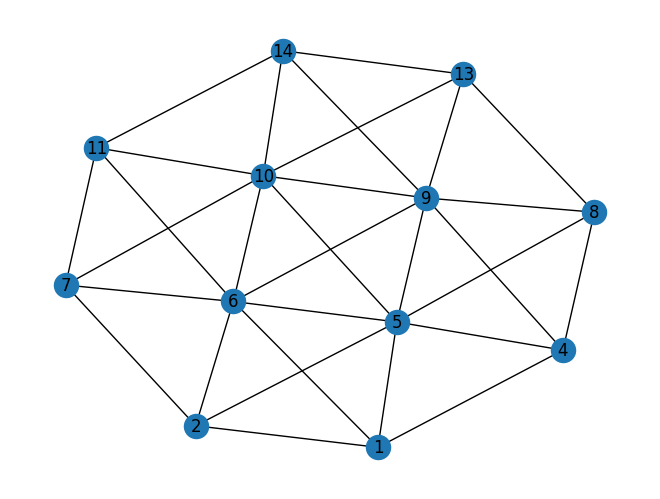

In [48]:
G = embedded_bqm.to_networkx_graph()
nx.draw(G, with_labels = True)

In [49]:
embedded_problem

{1: [6], 2: [7, 2], 3: [1, 4], 4: [11, 14, 9], 5: [5], 6: [10, 13, 8]}